In [27]:
# imports
import numpy as np
import matplotlib.pyplot as plt

from utils.graphene_hamiltonian import fill_pristine_hamiltonian, fill_vacancy_hamiltonian
from utils.graphene_positions import get_positions

Consider the hamiltonian of a pristine supercell of graphene $H_p$. We can diagonalize it using eigenvalue decomposition, or we can write it in the Wannier basis like so
\begin{equation}
    H_p = VDV^\textdagger = WAW^\textdagger.
\end{equation}
Now, suppose that introduce some defects in the supercell (vacancies or doping). This is a perturbation and the new Hamiltonian, which we can also diagonalize, is related to the pristine one by
\begin{equation}
    H_d = H_p + \Delta H = V'D'V'^\textdagger.
\end{equation}
We are interested in computing the matrix elements of the electron-defect interaction in the Wannier basis $W^\textdagger \Delta H W=W^\textdagger (H_d - H_p) W$. We can do so in the following way
\begin{align}
    W^\textdagger H_d W &= W^\textdagger H_p W + W^\textdagger \Delta H W, \\
    W^\textdagger V'D'V'^\textdagger W &= W^\textdagger W A W^\textdagger W + W^\textdagger \Delta H W,\\
\end{align}
which we can rearrange to get (using the orthonormality of the Wannier functions)
\begin{equation}
\boxed{
    W^\textdagger H_d W =  W^\textdagger V'D'V'^\textdagger W - A}
\end{equation}

The only thing missing is the matrix $A$. However, we know that the maximally localized Wannier functions (MLWFs) are related to the eigenstates of the Hamiltonian (the Bloch states) by a unitary transformation $U$
\begin{equation}
    W = VU \implies U = V^{-1}W.
\end{equation}
Putting this in the first equation above, we get an expression for $A$
\begin{equation}
    A = U^\textdagger D U
\end{equation}

####  Computing the electron-defect interaction matrix elements using this technique for a 5x5 graphene supercell with some vacancies

In [20]:
# getting the tight binding hamiltonian matrix for the pristine supercell
Nx = 5 # number of unit cell in x
Ny = 5  # number of unit cell in y
t = 2.7 # hopping parameter in eV
N = 2*Nx*Ny # number of atoms in the supercell

# nearest-neighbours hopping only
H_p = fill_pristine_hamiltonian(Nx, Ny, t, neighbours=1)

# getting the tight binding hamiltonian matrix for the defect supercell
# only once vacancy
H_d = fill_vacancy_hamiltonian(Nx, Ny, [4, 10, 24, 33, 37, 44, 49], t, neighbours=1)

# sanity checks
assert np.allclose(H_p, H_p.conj().T), "Hamiltonian must Hermitian"
assert np.allclose(H_d, H_d.conj().T), "Hamiltonian must be Hermitian"

# diagonalizing the hamiltonians
eigvals_p, V = np.linalg.eigh(H_p)
eigvals_d, V_ = np.linalg.eigh(H_d)

D = np.diag(eigvals_p)
D_ = np.diag(eigvals_d)

# Defining maximally localized Wannier functions
# For our simple models, these are just the p orbitals on each site
W = np.eye(N)

# unitary transformation between the Bloch functions and the Wannier functions
U = V.conj().T @ W # V is unitary since H_p is hermitian
A = U.conj().T @ D @ U

# sanity check
assert np.allclose(H_p, A), "Hamiltonian in real space should be the same"

# computing electron-defect interaction matrix elements in the Wannier basis
M = W.conj().T @ V_ @ D_ @ V_.conj().T @ W - A


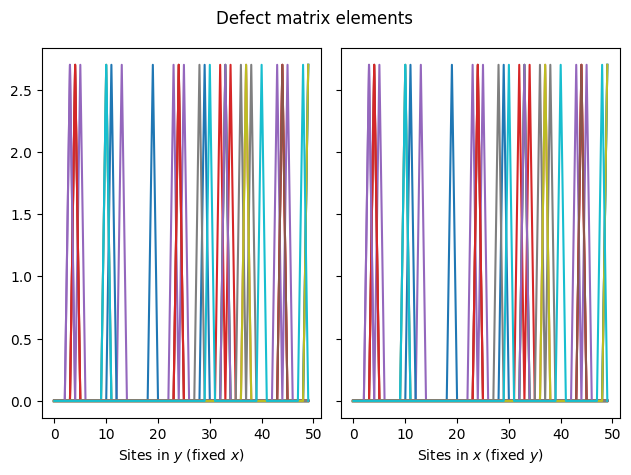

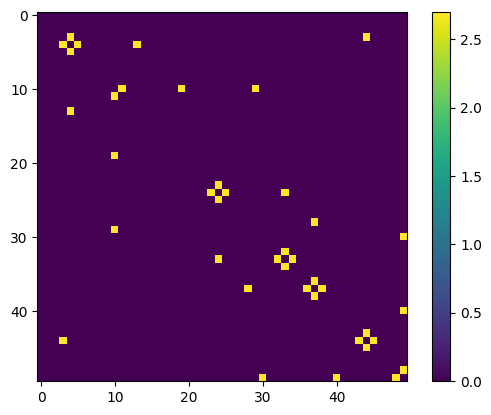

In [21]:
# plotting stuff
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Defect matrix elements')
for i in range(N):
    ax1.plot(M[i, :])
    ax1.set_xlabel("Sites in $y$ (fixed $x$)")
    ax2.plot(M[:, i])
    ax2.set_xlabel("Sites in $x$ (fixed $y$)")
plt.tight_layout()
plt.show()

plt.imshow(M.T)
plt.colorbar()
plt.show()

Why not just compute $W^\textdagger \Delta H W $ where $\Delta H = H_d - H_p$?

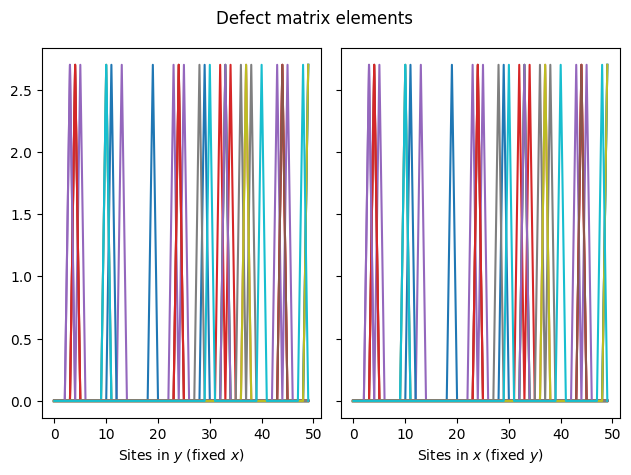

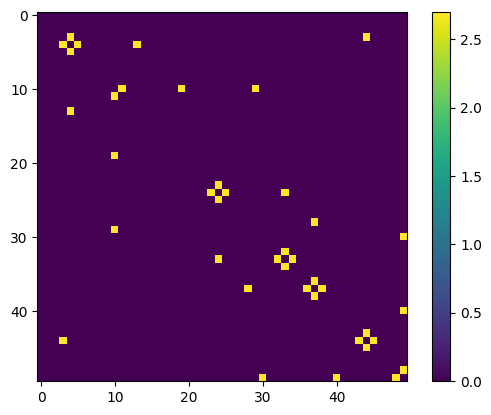

In [22]:
# more direct way, should see the same result
DeltaH = H_d - H_p
M = W.conj().T @ DeltaH @ W
# plotting stuff
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Defect matrix elements')
for i in range(N):
    ax1.plot(M[i, :])
    ax1.set_xlabel("Sites in $y$ (fixed $x$)")
    ax2.plot(M[:, i])
    ax2.set_xlabel("Sites in $x$ (fixed $y$)")
plt.tight_layout()
plt.show()

plt.imshow(M.T)
plt.colorbar()
plt.show()

As a comparison, let's use the Bloch states (which are delocalized over the supercell) to compute the electron-defect interaction matrix elements. We should get a matrix that is much less sparse and localized than the one in the Wannier basis.

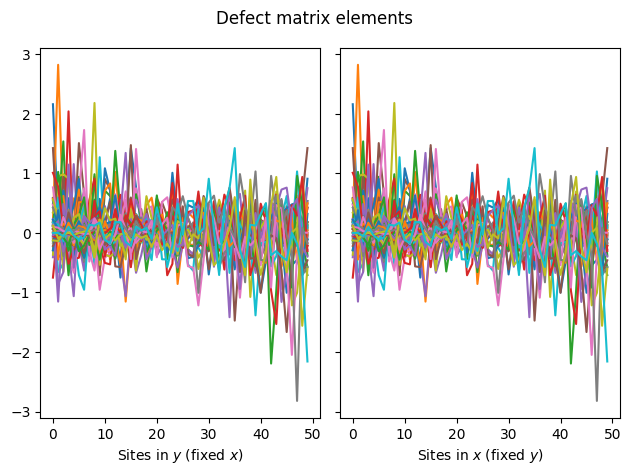

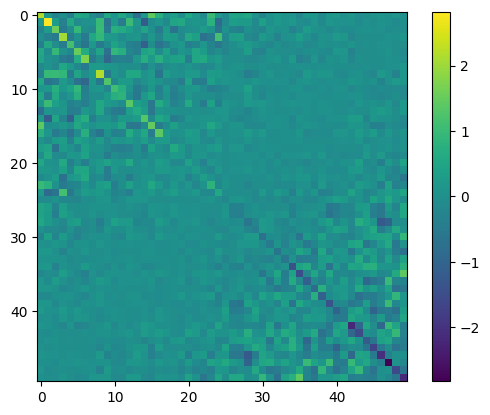

In [23]:
# Using the Bloch states to compute the matrix elements
# we should see a much less sparse and localized matrix
M = V.conj().T @ DeltaH @ V
# plotting stuff
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
fig.suptitle('Defect matrix elements')
for i in range(N):
    ax1.plot(M[i, :])
    ax1.set_xlabel("Sites in $y$ (fixed $x$)")
    ax2.plot(M[:, i])
    ax2.set_xlabel("Sites in $x$ (fixed $y$)")
plt.tight_layout()
plt.show()

plt.imshow(M.T)
plt.colorbar()
plt.show()

#### Green's function and transfer matrix formalism
We can have some fun and apply the many-body formalism to this problem to extract some physically interesting quantities. The central object is the interacting Green's function of the perturbed system, defined as
\begin{equation}
    G(\omega) = G_0(\omega) + G_0(\omega)T(\omega)G_0(\omega)
\end{equation}
where
\begin{equation}
    G_0(\omega) =  (\omega + i\eta - H_p)^{-1},
\end{equation}
is the pristine Green's function and
\begin{equation}
    T(\omega) = M(1-G_0(\omega)M)^{-1}
\end{equation}
is the $T$-matrix.\\

From the interacting Green's function we can get a few interesting physical quantities. The full density of states (DOS)
\begin{equation}
    D(\omega) = -\frac{1}{\pi}\text{Im}[\text{Tr}\,G(\omega)],
\end{equation}
the spectral function
\begin{equation}
    A(k,\omega) = -\frac{1}{\pi}\text{Im}\,G(k,\omega),
\end{equation}
where $G(k,\omega)$ is the Fourier transform of the Green's function
\begin{equation}
G(k, \omega) = \sum_{ij}e^{-ikr_i}G_{ij}(\omega)e^{ikr_j}.
\end{equation}

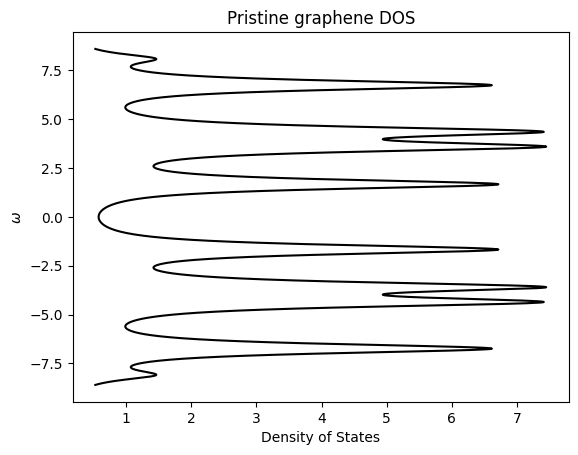

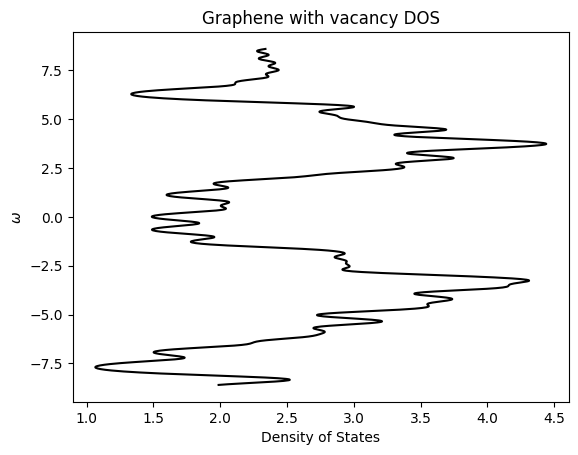

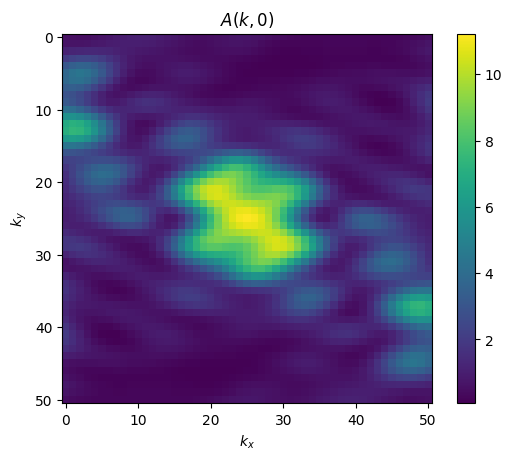

In [28]:
eta = 0.3 # broadening factor
a = 1 # graphene lattice constant, number doesnt really matter here
omega = np.linspace(D.min() - 0.5, D.max() + 0.5, 1001) # frequency array
L = len(omega)

# initialyzing the objects
G0 = np.zeros((N,N, L), dtype=complex)
T = np.zeros((N,N, L), dtype=complex)
G = np.zeros((N,N,L), dtype=complex)
I = np.eye(N)

# constructing the pristine Green's function
for i, w in enumerate(omega):
    G0[:,:, i] = np.linalg.inv((w + eta*1j)*I - H_p)

#  constructing the T-matrix and interacting Green's function
for i, w in enumerate(omega):
    T[:,:,i] = M @ np.linalg.inv(I - G0[:,:, i] @ M)
    G[:,:,i] = G0[:,:, i] + G0[:,:,i] @ T[:,:,i] @ G0[:,:,i]
    
# sanity check, pristine graphene DOS
dos = -np.imag(np.trace(G0, axis1=0, axis2=1)) / np.pi
plt.plot(dos, omega, 'k-')
plt.title("Pristine graphene DOS")
plt.xlabel("Density of States")
plt.ylabel("$\\omega$")
plt.show()

# defect graphene DOS
dos = -np.imag(np.trace(G, axis1=0, axis2=1)) / np.pi
plt.plot(dos, omega, 'k-')
plt.title("Graphene with vacancy DOS")
plt.xlabel("Density of States")
plt.ylabel("$\\omega$")
plt.show()

# computing the spectral function
Nk = 51
ks = np.linspace(-np.pi/a, np.pi/a, Nk)
# k-space interacting Green's function
Gk = np.zeros((Nk,Nk, L), dtype=complex)
# getting real space positions for the double fourier transform
positions = get_positions(Nx, Ny, a)
# double fourier transform
for ix, kx in enumerate(ks):
    for iy, ky in enumerate(ks):
        phase = np.exp(-1j * (kx * positions[:,0] + ky * positions[:,1]))
        phase_dag = phase.conj()
        
        for l in range(L):
            Gk[ix, iy, l] = phase_dag @ ( G[:, : , l] @ phase)
# spectral function
Ak = -np.imag(Gk) / np.pi

plt.imshow(Ak[:,:,0])
plt.colorbar()
plt.xlabel("$k_x$")
plt.ylabel("$k_y$")
plt.title("$A(k,0)$")
plt.show()